# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [69]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [6]:
data_df.head()

,followers_count,friends_count,statuses_count,favourites_count,listed_count,created_year,name_words,screen_name_length,description_length
uid,,,,,,,,,
40585382,0.000107,0.005356,0.072324,0.001628,0.001943,0.3,0.111111,0.692308,0.703030
30005269,0.000027,0.001552,0.010230,0.000263,0.000452,0.3,0.111111,0.384615,0.933333
3314758074,0.000317,0.015640,0.002684,0.015579,0.000867,0.9,0.111111,0.923077,0.903030
14311688,0.000025,0.001622,0.010527,0.000354,0.000512,0.2,0.111111,0.923077,0.690909
110457801,0.000021,0.001487,0.053145,0.006863,0.000354,0.4,0.111111,0.384615,0.915152


In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("p.olshevskaya") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [7]:
class Clustering:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, n_clusters = 5, linkage = 'single'):
        
        self.n_clusters = n_clusters
        self.linkage = linkage

        return
        
        
    def distance(self,C_i,C_j):
        linkage_type = ['single','complete','average']
        if self.linkage == linkage_type[0] or self.linkage not in linkage_type:
            d = np.linalg.norm(C_i[0] - C_j[0])
            for x in C_i:
                for y in C_j:
                    if np.linalg.norm(x-y) < d:
                        d = np.linalg.norm(x-y)
            return d
            
        if self.linkage == linkage_type[1]:
            d = 0
            for x in C_i:
                for y in C_j:
                    if np.linalg.norm(x-y) > d:
                        d = np.linalg.norm(x-y)
            return d
                        
        
        if self.linkage == linkage_type[2]:
            d = 0
            for x in C_i:
                for y in C_j:
                    d+=np.linalg.norm(x-y) 
            d = d/(len(C_i)*len(C_j))
            return d
            
            
    
    
    def fit(self, x, y=None):
        self.x_len = len(x)
        return self
    
    def predict(self, x):
        n_items = self.x_len
        n = n_items
        C_list = []
        for i in xrange(n_items):
            C_list.append([x[i]])
            
        while(n > self.n_clusters):
            i_min = -1
            j_min = -1
            min_dist = float('inf')
            for i in xrange(n):
                for j in xrange(i+1,n):
                    dist = self.distance(C_list[i],C_list[j])
                    if dist < min_dist:
                        min_dist = dist
                        i_min = i
                        j_min = j
            C_list[i_min].extend(C_list[j_min])
            C_list.pop(j_min)
            n = n - 1
            if n%100 == 0:
                print(n)
            
            
        
        res = np.zeros(self.x_len)
        for i in xrange(self.x_len):
            for k in range(self.n_clusters):
                for k_l in xrange(len(C_list[k])):
                    if (x[i] == C_list[k][k_l]).all():
                        res[i] = k
        
        return res
            
        
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

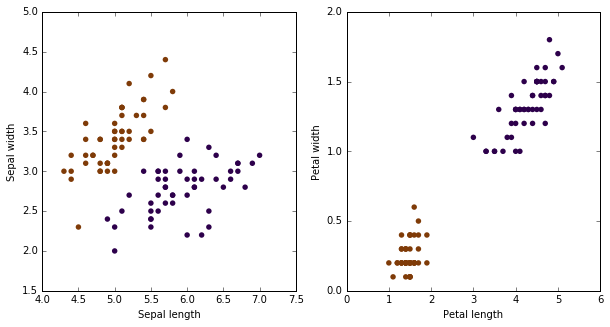

In [9]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [13]:
pred_iris = Clustering(n_clusters = 2, linkage = 'single').fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


In [14]:
pred_iris = Clustering(n_clusters = 2, linkage = 'complete').fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


In [12]:
pred_iris = Clustering(n_clusters = 2, linkage = 'average').fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

реализуем средний диаметр

In [41]:
def quality(x, y):
    d_mean = 0
    for i in range(len(unique(y))):
        d = 0
        for j in range(len(x)):
            for k in range(j+1, len(x)):
                if y[j] == i and y[k]==i:
                    if np.linalg.norm(x[j]-x[k]) > d:
                        d = np.linalg.norm(x[j]-x[k])
                    
        d_mean+= d
    
    return d_mean/len(unique(y))

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [69]:
np.random.shuffle(x)
x_crit = x[:int(0.05*len(x))]

324

diametr = 1.93073 n_clusters = 1
diametr = 0.73869 n_clusters = 2
diametr = 0.49246 n_clusters = 3
diametr = 0.36935 n_clusters = 4
diametr = 0.35169 n_clusters = 5
diametr = 0.29307 n_clusters = 6
diametr = 0.25120 n_clusters = 7
diametr = 0.21980 n_clusters = 8
diametr = 0.21981 n_clusters = 9
diametr = 0.19019 n_clusters = 10
diametr = 0.17290 n_clusters = 11
diametr = 0.14450 n_clusters = 12
diametr = 0.11647 n_clusters = 13
diametr = 0.09354 n_clusters = 14
diametr = 0.08730 n_clusters = 15
diametr = 0.08184 n_clusters = 16
diametr = 0.07703 n_clusters = 17
diametr = 0.07275 n_clusters = 18
diametr = 0.07961 n_clusters = 19
diametr = 0.07563 n_clusters = 20


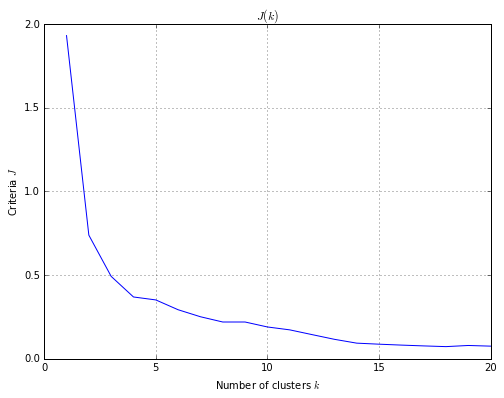

In [70]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(n_clusters=k, linkage='single')
    y = cls.fit_predict(x_crit)
    criteria[i] = quality(x_crit, y)
    print("diametr = %0.5f" % criteria[i] + " n_clusters = %d" % k)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

diametr = 1.93073 n_clusters = 1
diametr = 0.73869 n_clusters = 2
diametr = 0.80026 n_clusters = 3
diametr = 0.73403 n_clusters = 4
diametr = 0.72826 n_clusters = 5
diametr = 0.67544 n_clusters = 6
diametr = 0.65030 n_clusters = 7
diametr = 0.62017 n_clusters = 8
diametr = 0.58689 n_clusters = 9
diametr = 0.55982 n_clusters = 10
diametr = 0.56354 n_clusters = 11
diametr = 0.54045 n_clusters = 12
diametr = 0.51646 n_clusters = 13
diametr = 0.49044 n_clusters = 14
diametr = 0.47690 n_clusters = 15
diametr = 0.46036 n_clusters = 16
diametr = 0.45145 n_clusters = 17
diametr = 0.44640 n_clusters = 18
diametr = 0.40722 n_clusters = 19
diametr = 0.39574 n_clusters = 20


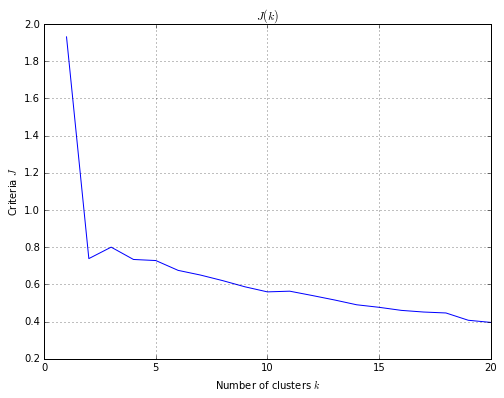

In [72]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(n_clusters=k, linkage='complete')
    y = cls.fit_predict(x_crit)
    criteria[i] = quality(x_crit, y)
    print("diametr = %0.5f" % criteria[i] + " n_clusters = %d" % k)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [70]:
np.random.shuffle(x)
x_mini = x[:int(0.05*len(x))]

In [71]:
k = 4
cls = Clustering(n_clusters=k, linkage='complete')
y = cls.fit_predict(x_mini)

300
200
100


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 344 / 344
[t-SNE] Mean sigma: 0.149142
[t-SNE] Error after 100 iterations with early exaggeration: 0.967233
[t-SNE] Error after 175 iterations: 1.735021


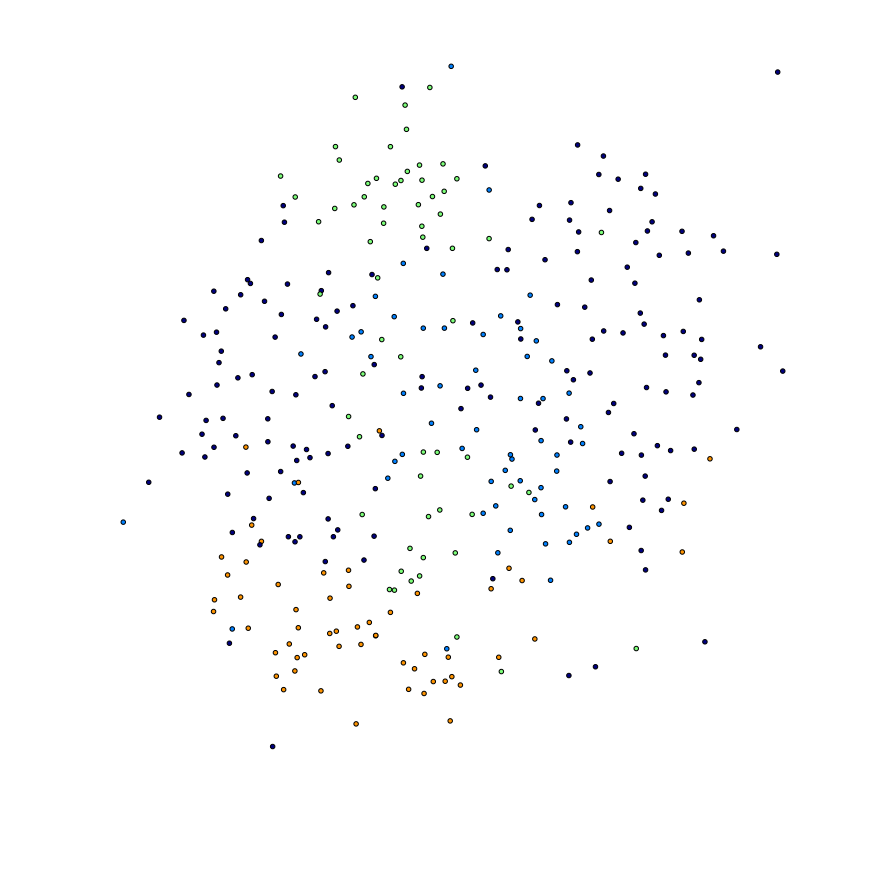

In [72]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x_mini)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

результат на 5% данных, поставила на всех считаться

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

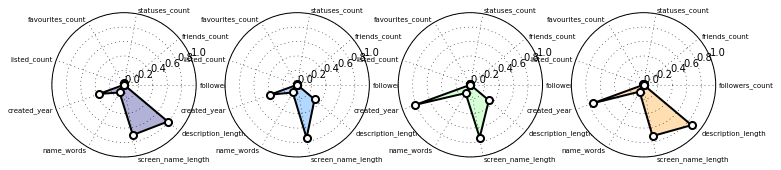

In [73]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x_mini[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(5, 5, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.